In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from lime import lime_tabular

Load and split dataset

In [3]:
path = "./data/feature_engineered_dataset.csv"
df = pd.read_csv(path, index_col=None )

In [4]:
print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]:,} cols')

The dataset has 5,644,012 rows and 15 cols


In [5]:
# train set is any day before 16 Mar 2016
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
cutoff_date = pd.Timestamp("2016-03-16")
train = df[df['tpep_pickup_datetime'] < cutoff_date]
test = df[df['tpep_pickup_datetime'] >= cutoff_date]

In [6]:
# This is about 80/20 train test split
print(f'The train set has {train.shape[0]:,} rows')
print(f'The test set has {test.shape[0]:,} rows')

The train set has 4,643,397 rows
The test set has 1,000,615 rows


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4643397 entries, 0 to 5643320
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   pickup_longitude      float64       
 1   pickup_latitude       float64       
 2   tpep_pickup_datetime  datetime64[ns]
 3   current_pickup_count  int64         
 4   is_weekend            int64         
 5   day_of_week           int64         
 6   hour_of_day           int64         
 7   temp                  float64       
 8   prcp                  float64       
 9   pickup_geohash        object        
 10  target_pickup_count   int64         
 11  pickup_count_1h_ago   int64         
 12  pickup_count_2h_ago   int64         
 13  month                 int64         
 14  day_of_month          int64         
dtypes: datetime64[ns](1), float64(4), int64(9), object(1)
memory usage: 566.8+ MB


In [8]:
# Note: removed geohashing as model performs better without that column
# Create x and y for train set
x_train = train.drop(columns=["tpep_pickup_datetime", "target_pickup_count",
                              "pickup_geohash"])
y_train = train["target_pickup_count"]

# Create x and y for test set
x_test = test.drop(columns=["tpep_pickup_datetime", "target_pickup_count",
                            "pickup_geohash"
                            ])
y_test = test["target_pickup_count"]

Set categorical features

In [9]:
# define list of categorical variables
category_list = ["day_of_week", "hour_of_day", 
                 "pickup_geohash", "target_pickup_count",
                 "month", "day_of_month"
                ]

In [10]:
# convert selected columns in x_train to category 
for col in x_train.columns:
    if col in category_list:
        x_train[col] = x_train[col].astype('category')

In [11]:
# convert selected columns in x_test to category 
for col in x_test.columns:
    if col in category_list:
        x_test[col] = x_test[col].astype('category')

Set up XGBoost

In [12]:
# instantiate XGBoostRegressor

es = EarlyStopping(
    rounds=5,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="mean_absolute_error",
)

eval_result = {}

model = XGBRegressor(
    n_estimators=250,
    max_depth=3,
    learning_rate=0.05,
    enable_categorical=True,
    verbosity=2,
    subsample=0.75,
    colsample_bytree=0.8,
    eval_metric=mean_absolute_error,
    random_state=42,
    callbacks = [es]
    )


Train model

In [13]:
model.fit(x_train, y_train, eval_set=[(x_test, y_test)])

[0]	validation_0-rmse:9.16563	validation_0-mean_absolute_error:5.20540
[1]	validation_0-rmse:8.87130	validation_0-mean_absolute_error:5.02882
[2]	validation_0-rmse:8.59480	validation_0-mean_absolute_error:4.86231
[3]	validation_0-rmse:8.33600	validation_0-mean_absolute_error:4.70618
[4]	validation_0-rmse:8.09482	validation_0-mean_absolute_error:4.56089
[5]	validation_0-rmse:7.86925	validation_0-mean_absolute_error:4.42611
[6]	validation_0-rmse:7.69854	validation_0-mean_absolute_error:4.31634
[7]	validation_0-rmse:7.49904	validation_0-mean_absolute_error:4.19846
[8]	validation_0-rmse:7.31429	validation_0-mean_absolute_error:4.08967
[9]	validation_0-rmse:7.14132	validation_0-mean_absolute_error:3.98683
[10]	validation_0-rmse:6.98133	validation_0-mean_absolute_error:3.89115
[11]	validation_0-rmse:6.83398	validation_0-mean_absolute_error:3.80231
[12]	validation_0-rmse:6.69718	validation_0-mean_absolute_error:3.72013
[13]	validation_0-rmse:6.57057	validation_0-mean_absolute_error:3.64456
[1

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x0000011F70CE1D50>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True,
             eval_metric=<function mean_absolute_error at 0x0000011F6F0FF7E0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Evaluate model

In [14]:
# best iteration on val set
print("Best validation MAE:", model.best_score)

Best validation MAE: 2.427962


In [15]:
# Compute train metrics to inspect for overfitting
y_pred_train = model.predict(x_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)

In [16]:
print("train MAE:", train_mae)
print("train RMSE:", train_rmse)

train MAE: 2.4247848423025853
train RMSE: 4.6620188365364275


Save and reload model

In [17]:
# Save model 
filepath = './models/xgboost_model.json'
model.save_model(filepath)

In [18]:
# Test loading model
filepath = './models/xgboost_model.json'
model_load = XGBRegressor()
model_load.load_model(filepath)

In [19]:
# Print out best MAE on validation set
print("best (lowest) MAE on val:", model_load.best_score)

best (lowest) MAE on val: 2.427962


Make predictions on test set

In [20]:
# Make predictions
y_pred_test = model_load.predict(x_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
print("Prediction MAE on validation set:", test_mae)
print("Prediction RMSE on validation set:", test_rmse)

Prediction MAE on validation set: 2.4279613708458188
Prediction RMSE on validation set: 4.6366691208068085


In [21]:
# Create predictions dataframe
predictions_df = test.copy()
predictions_df['hourly_predictions'] = y_pred_test

In [22]:
# save predictions dataframe
filepath = './predictions/prediction_df.csv'
predictions_df.to_csv(filepath)

Feature importance

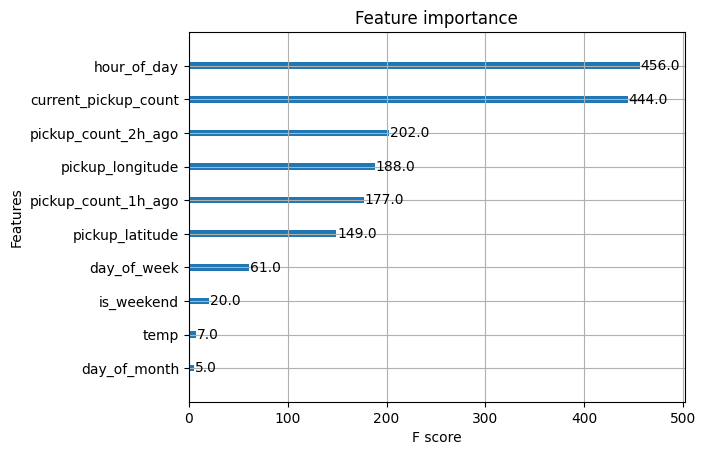

In [27]:
plot_importance(model_load)
plt.show()

In [24]:
category_list = ['day_of_week',
 'hour_of_day',
 'month',
 'day_of_month']

categorical_indices = [x_train.columns.get_loc(col) for col in category_list]


In [25]:
# instantiate LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    x_train.values,
    feature_names=x_train.columns,
    categorical_features=categorical_indices,
    mode="regression"
)

In [26]:
# Create lime explaination for row 6 instance in x_test
exp = explainer.explain_instance(x_test.iloc[5].values, model_load.predict)
filepath = './predictions/lime_explanation_iloc06.html'
exp.save_to_file(filepath)